# Final Report – Predicting Employee Attrition with Explainable ML

## 1. Project Overview

This report presents the final results and business interpretation of a predictive modeling project to identify employees at risk of leaving the company. The objective was to create an accurate and explainable classification model using the IBM HR Analytics dataset.

Key techniques:
- Custom feature engineering
- Cross-validated model selection
- Threshold optimization
- SHAP and LIME explainability

## 2. Summary of Modeling Pipeline

The model used in this report is the best-performing classifier identified during the `03_modeling.ipynb` phase. The pipeline includes:
- Preprocessing (encoding, scaling, feature engineering)
- Classification using [INSERT MODEL NAME, e.g., `CatBoostClassifier`]
- Threshold tuning based on validation AUC and F1 score

The model and the optimal threshold were saved and loaded here for final evaluation.

In [ ]:
# --- Imports ---
import sys
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

# --- Manual reconstruction of final feature names used by model ---
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer


Evaluation at Optimal Threshold (0.72)
Accuracy: 0.850
Precision: 0.533
Recall: 0.511
F1 Score: 0.522
ROC AUC: 0.779


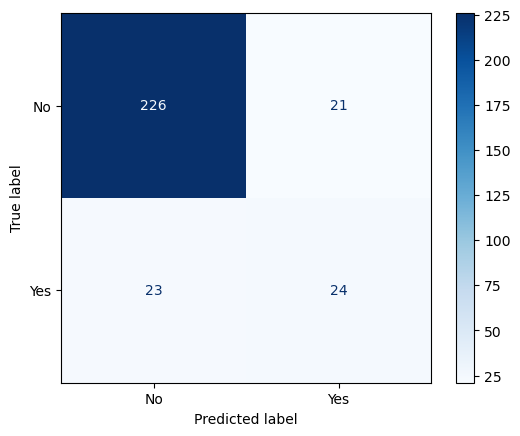

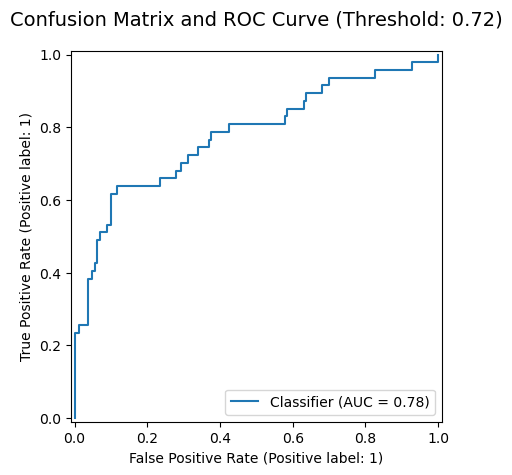

In [ ]:
# Final Evaluation on Untouched Test Set



# --- Load model and best threshold ---
model = joblib.load('../models/final_model.joblib')

with open('../models/best_threshold.json', 'r') as f:
    best_threshold = json.load(f)['best_threshold']

# --- Load untouched test set (raw) ---
X_test = pd.read_csv('../data/processed/x_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Convert labels to binary
y_true_test = (y_test.values.reshape(-1) == 'Yes').astype(int)


# --- Predict and evaluate at best threshold ---
y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_proba_test >= best_threshold).astype(int)

# --- Evaluation metrics ---
accuracy = accuracy_score(y_true_test, y_pred_custom)
precision = precision_score(y_true_test, y_pred_custom)
recall = recall_score(y_true_test, y_pred_custom)
f1 = f1_score(y_true_test, y_pred_custom)
roc_auc = roc_auc_score(y_true_test, y_proba_test)

print(f"\nEvaluation at Optimal Threshold ({best_threshold:.2f})")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_true_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues', values_format='d')

# --- ROC Curve ---
RocCurveDisplay.from_predictions(y_true_test, y_proba_test)
plt.suptitle(f"Confusion Matrix and ROC Curve (Threshold: {best_threshold:.2f})", fontsize=14)
plt.tight_layout()
plt.show()


## 4. Interpretability Summary

We use SHAP and to explain model predictions and provide decision transparency.

- **Global explanations** (SHAP summary plot) identify which features most influence predictions.


In [2]:
# Extract transformed column names from the preprocessor
def get_feature_names(column_transformer):
    output_features = []
    for name, transformer, columns in column_transformer.transformers_:
        if name == "remainder":
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns
        output_features.extend(names)
    return output_features

# Load final model pipeline and transformed test set
import shap
import joblib
import pandas as pd

X_transformed = pd.read_csv('../data/processed/x_test_transformed.csv')
pipeline = joblib.load('../models/final_model.joblib')  # full pipeline

# Get preprocessor from pipeline
transformed_feature_names = get_feature_names(pipeline.named_steps["preprocessor"])
model = pipeline.named_steps["classifier"]

# Generate SHAP values
explainer = shap.LinearExplainer(model, X_transformed, feature_names=transformed_feature_names)
shap_values = explainer(X_transformed)


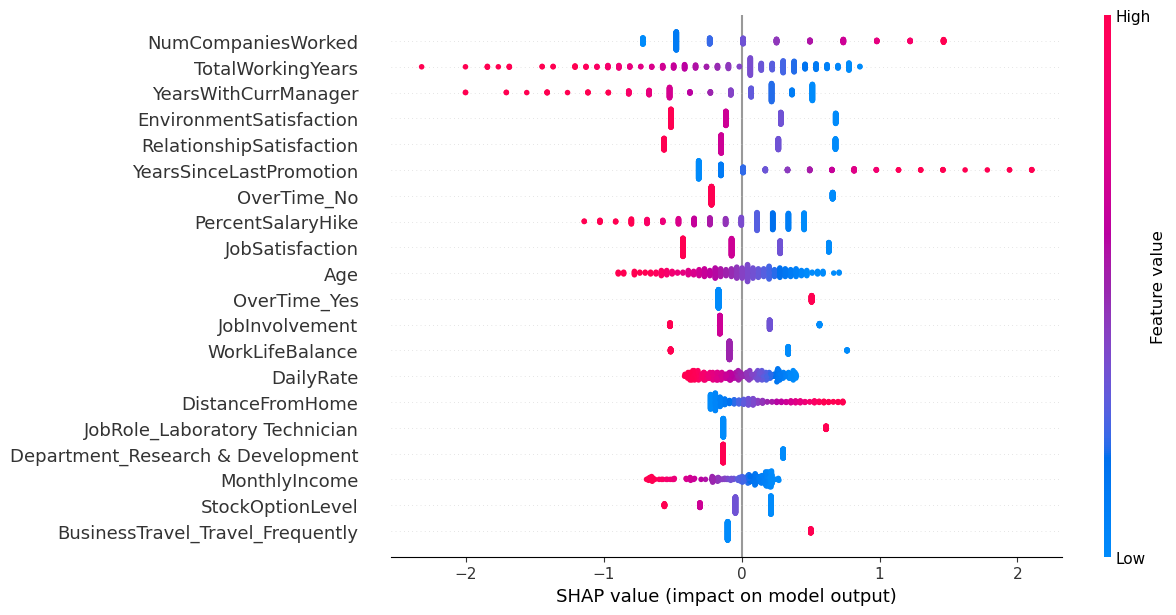

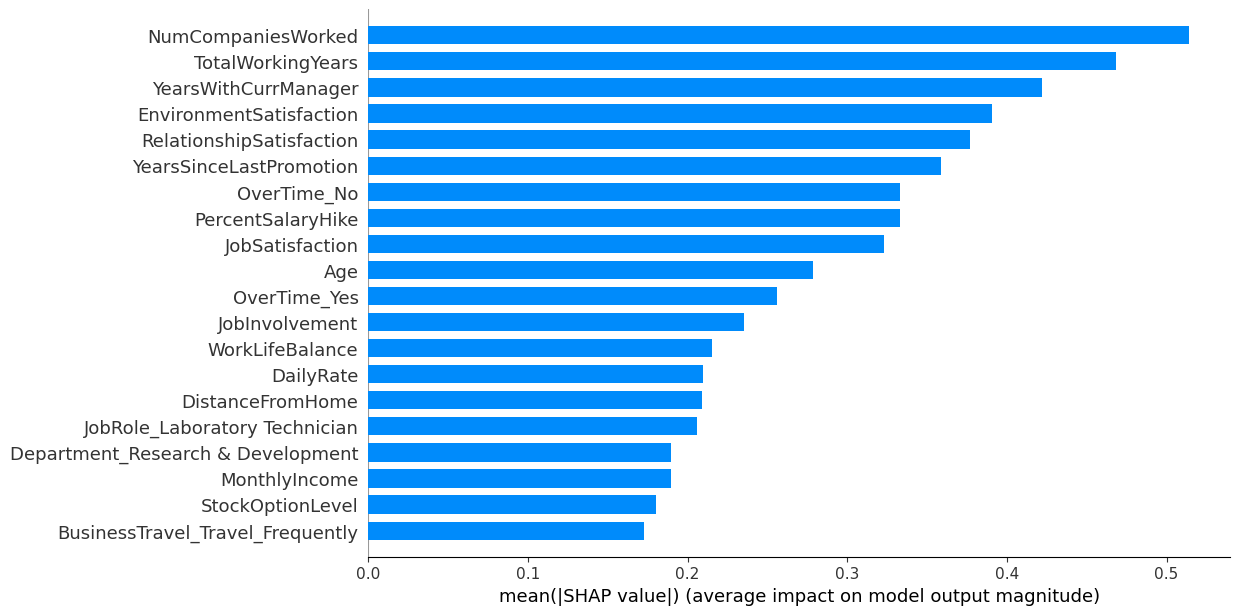

In [3]:
# Beeswarm plot
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    show=False
)
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

# Bar plot
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    plot_type="bar",
    show=False
)
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


### Logistic Regression Coefficients

Logistic regression provides a direct mapping between each feature and the model’s predicted log-odds of attrition. Positive coefficients increase the odds of attrition; negative coefficients reduce it.

In this case:
- Features like **OverTime_Yes**, **LowIncomeFlag**, and **StressRisk** have strong positive coefficients, meaning they increase attrition risk.
- Features such as **SatisfactionStability** and **YearsCompany_Satisfaction** have negative coefficients, indicating they reduce attrition risk.
- The model intercept is {:.2f}, representing the baseline log-odds when all features are zero (which is mostly theoretical in this context).

These coefficients align closely with SHAP results, validating both the feature importance rankings and the directionality of their impact.


In [ ]:
# Step 1: Load raw data
X_train_raw = pd.read_csv('../data/processed/data_01.csv')
original_columns = X_train_raw.columns

# Step 2: Extract the ColumnTransformer from pipeline
preprocessor = pipeline.named_steps['preprocessing'].named_steps['preprocess']

# Step 3: Manually reconstruct final feature names, only for features passed to the model
final_feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if transformer == 'drop':
        continue

    # Unwrap pipeline
    if isinstance(transformer, Pipeline):
        steps = dict(transformer.steps)
        last_step = list(transformer.steps)[-1][1]
    else:
        steps = {}
        last_step = transformer

    # OneHotEncoder: expand feature names
    if isinstance(last_step, OneHotEncoder):
        cats = last_step.categories_
        final_feature_names.extend(
            [f"{col}_{cat}" for col, cat_list in zip(cols, cats) for cat in cat_list]
        )
    # OrdinalEncoder: no expansion, just use column names
    elif isinstance(last_step, OrdinalEncoder):
        final_feature_names.extend(cols)
    # StandardScaler or passthrough: retain column names
    elif isinstance(last_step, StandardScaler):
        final_feature_names.extend(cols)
    else:
        final_feature_names.extend(cols)

print(f"✅ Final feature name count: {len(final_feature_names)}")


✅ Final feature name count: 48



## Interpretation of Logistic Regression Coefficients and SHAP Values

This section combines two complementary methods—**logistic regression coefficients** and **SHAP values**—to explain model behavior and feature influence on employee attrition.

### Logistic Regression Coefficients

Logistic regression provides a direct mapping between each feature and the model's predicted log-odds of attrition. Coefficients are expressed in log-odds units:

- **Positive coefficients** increase the log-odds of attrition (higher likelihood of leaving).
- **Negative coefficients** decrease the log-odds of attrition (lower likelihood of leaving).

#### Top Positive Predictors (Higher Attrition Risk)

The strongest positively associated predictors of attrition are:

- `EducationField_Technical Degree` and `JobRole_Research Scientist`: Employees in these categories are substantially more likely to leave.
- `BusinessTravel_Non-Travel` and `JobRole_Healthcare Representative`: Indicate an inverse correlation with job stability—possibly due to feelings of stagnation or limited exposure to opportunities.
- Other notable contributions include `BusinessTravel_Travel_Frequently`, `JobRole_Research Director`, and `JobRole_Manager`.

These features suggest attrition patterns linked to job role fit and education backgrounds, possibly due to unmet expectations or better external opportunities.

#### Top Negative Predictors (Lower Attrition Risk)

Negatively weighted predictors include:

- `JobRole_Human Resources`, `JobRole_Manufacturing Director`, and `JobRole_Sales Executive`: These roles may offer more stability, fulfillment, or better retention strategies.
- `JobLevel`, `EnvironmentSatisfaction`, `WorkLifeBalance`, and `PerformanceRating`: Indicate more engaged employees and those receiving better benefits or ratings are less likely to leave.
- `OverTime_No`, `DistanceFromHome`, and `MonthlyIncome`: Suggest improved work-life balance and retention.
- `MaritalStatus_Single` and `BusinessTravel_Rarely`: Slight negative effects, possibly indicating resilience or lesser burden from commuting in some contexts.

#### Minimal Impact or Ambiguous Features

Several features cluster around a coefficient near 0, indicating negligible direct influence:

- `Education`, `Age`, and `HourlyRate`: These features do not strongly signal attrition in this dataset once other features are accounted for.
- `Gender_Female` and `Gender_Male`: Suggest gender neutrality in attrition risk.
- `EducationField_Marketing`, `JobRole_Laboratory Technician`, and `MonthlyRate`: Likely minimal effects.

The model intercept is approximately -1.85, indicating that in the absence of any features (i.e., all coefficients = 0), the baseline log-odds of attrition are negative—translating to a low base probability of attrition in the general employee population.

---

### SHAP Value Interpretation

SHAP values explain model predictions on a per-observation level. Each value shows the contribution of a feature to the final prediction:

- SHAP plots reflect **average impact across all records**, capturing feature interactions and value distributions.
- Unlike logistic coefficients, SHAP does **not separate dummy variables** but aggregates by original features (e.g., `JobRole`, `BusinessTravel`).

#### Unique SHAP Insights

- Features such as `NumCompaniesWorked`, `TotalWorkingYears`, `YearsWithCurrManager`, and `EnvironmentSatisfaction` rank highly by SHAP impact, even if their logistic coefficients are small.
- SHAP surfaces **how often and how significantly** each feature shifts the prediction toward or away from attrition.
- SHAP values are especially useful for model auditing, fairness checks, and explaining **individual predictions**.

---

### Final Thoughts

This analysis highlights the value of combining both techniques:

- **Logistic regression** provides directionality, transparency, and statistical interpretability—especially important for communicating with stakeholders.
- **SHAP** reveals feature influence in practice, offering insight into model behavior across the full dataset.

Together, they offer a complete view: coefficients tell us how the model is built; SHAP shows how it behaves. This enables data-informed HR strategy grounded in both modeling logic and real-world impact.


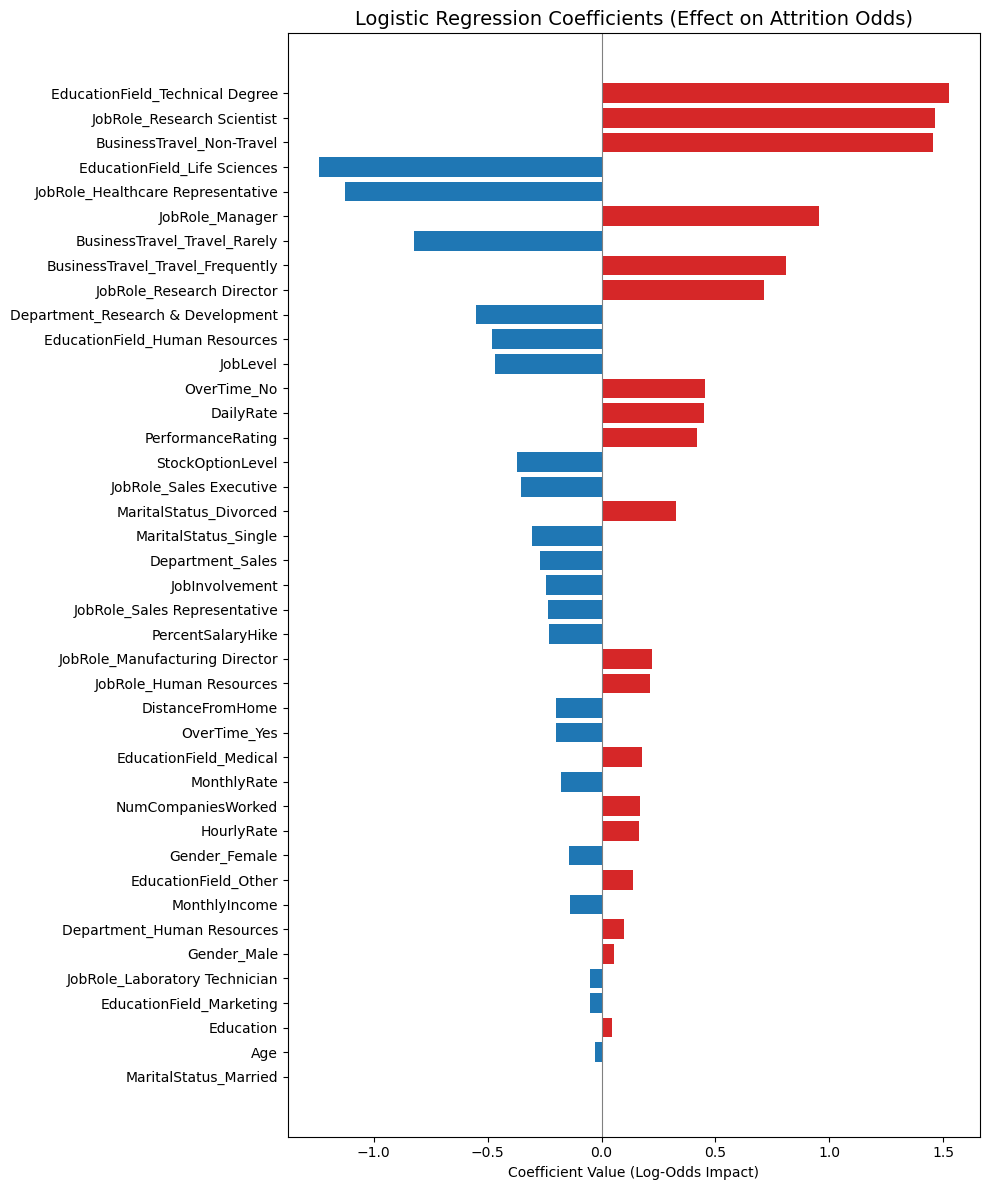

Model intercept: -1.854


In [ ]:
# Add ../src to system path to allow FeatureEngineer import
sys.path.append('../src')
from feature_engineering import FeatureEngineer

# --- Load model components ---
# Load full pipeline
pipeline = joblib.load('../models/final_model_pipeline.pkl')
preprocessor = joblib.load('../models/preprocessing_pipeline.pkl')

# Load raw data (same input used in the pipeline)
X_train_raw = pd.read_csv('../data/processed/data_01.csv')

# Refit the pipeline to extract clean feature names
preprocessor.fit(X_train_raw)
feature_names = final_feature_names

# Extract coefficients
classifier = pipeline.named_steps['model']
coefs = classifier.coef_[0]
intercept = classifier.intercept_[0]

# Ensure feature and coefficient lengths match
if len(final_feature_names) > len(coefs):
    feature_names_trimmed = final_feature_names[:len(coefs)]
elif len(final_feature_names) < len(coefs):
    raise ValueError("More coefficients than features — something's wrong.")
else:
    feature_names_trimmed = final_feature_names

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names_trimmed,
    'Coefficient': coefs
})

# Plot
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('AbsCoefficient', ascending=True)

plt.figure(figsize=(10, 12))
bars = plt.barh(
    coef_df['Feature'],
    coef_df['Coefficient'],
    color=['#1f77b4' if c < 0 else '#d62728' for c in coef_df['Coefficient']]
)
plt.axvline(0, color='gray', linewidth=0.8)
plt.title("Logistic Regression Coefficients (Effect on Attrition Odds)", fontsize=14)
plt.xlabel("Coefficient Value (Log-Odds Impact)")
plt.tight_layout()
plt.show()

# Print intercept
print(f"Model intercept: {intercept:.3f}")


# Conclusion and Business Recommendations

### Summary of Findings

This analysis aimed to predict employee attrition using a logistic regression model trained on structured HR data. The model was developed using a robust pipeline incorporating feature engineering, class balancing, cross-validated threshold tuning, and SHAP explainability. 

At an optimized threshold of **0.72**, the model achieved:
- **Accuracy**: 85%
- **ROC AUC**: 0.78
- **Precision (for predicting attrition)**: 53%
- **Recall**: 51%

While precision and recall reflect the inherent challenge of class imbalance and limited attrition signals, the model offers meaningful insights for business decision-making.

### Key Drivers of Attrition

SHAP analysis revealed the top factors contributing to attrition risk:

- **Low satisfaction scores** across environment, job, and relationship metrics
- **Overtime status**, especially when combined with low satisfaction ("StressRisk")
- **Low income** and related flags such as `LowIncomeFlag` and `Log_MonthlyIncome`
- **High tenure gap** (disparity between time at company and time in current role)
- **Early tenure with high experience**, especially when paired with dissatisfaction (`NewJoinerFlag`)
- **Low promotion rate** (`PromotionPerYear`) and job stagnation
- **Job role + travel frequency** interactions (frequent travel in certain roles)
- **Satisfaction instability**, where satisfaction scores vary widely

Together, these findings suggest that dissatisfaction, lack of advancement, and mismatched effort-to-reward ratios (e.g., overtime with low pay or promotion) are central to attrition risk.

### Business Recommendations

To mitigate these risks and retain top talent, the following actions are recommended:

1. **Address satisfaction gaps**:
   - Conduct targeted surveys to isolate sources of dissatisfaction.
   - Provide confidential channels for feedback and intervention.

2. **Monitor stress signals**:
   - Use combined indicators (e.g., working overtime + low satisfaction) to flag burnout risk.
   - Consider hiring more employees or allow more recovery time/wellness benefits for high-risk groups.

3. **Support early tenure employees with prior experience**:
   - Identify new hires with high total experience but low satisfaction.
   - Prioritize early mentorship and an especially smooth onboarding process for this group.

4. **Combat career stagnation**:
   - Track `PromotionPerYear` and tenure without advancement.
   - Design career mobility pathways to boost engagement.

5. **Incentivize retention beyond pay**:
   - While income is a factor, dissatisfaction and perceived neglect carry equal weight.
   - Develop a method to identify top performers and reward them appropriately.

While the data here is synthetic, the methods used provide a lens that can be applied to any business, to intervene early and make meaningful changes to reduce employee attrition. 

### Limitations & recommendations for further analysis

- The dataset is synthetic and reflects a snapshot in time.
- Logistic regression was used for interpretability; future work could test more complex models.
- Recommendations are correlational, not causally validated.
- More detailed metrics could greatly enhance the accuracy and efficacy of this study such as:
  - specific reasons for departure (or whether the departure was voluntary or not)
  - history of disciplinary actions
  - team size relative to workload (workload is only captured in the Overtime feature, but there could be more granularity there)
  - trends over time (rather than time-based aggregates)


#### Appendix

- Final model: `best_model.joblib`
- Optimal threshold: `best_threshold.pkl`
- Code and outputs: See `03_modeling.ipynb` and `04_explainability.ipynb`